In [1]:
import numpy as np
from dataloader import SatelliteImagesGenerator
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import utils

In [2]:
image_dir = 'UCMerced_LandUse/Images/'

In [3]:
image_files = glob(image_dir+'/*/*tif')
print('FOUND {} IMAGES'.format(len(image_files)))

FOUND 2100 IMAGES


In [4]:
random.shuffle(image_files)

In [5]:
test_size = 0.1
train_image_files = image_files[int(test_size*len(image_files)):]
test_image_files = image_files[:int(test_size*len(image_files))]

In [6]:
BATCH_SIZE = 32
IMAGE_DIMENSION = (128, 128)
traning_image_generator = SatelliteImagesGenerator(image_files=train_image_files,
                                                   dim=IMAGE_DIMENSION,
                                                   saturation_factor=3,
                                                   batch_size=BATCH_SIZE)  
testing_image_generator = SatelliteImagesGenerator(image_files=test_image_files,
                                                   dim=IMAGE_DIMENSION,
                                                   saturation_factor=3,
                                                   batch_size=BATCH_SIZE)  

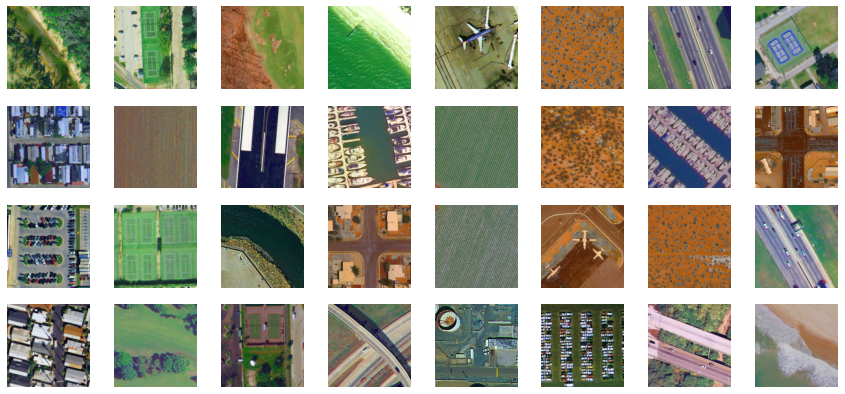

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
L_images, AB_images = traning_image_generator[0]
for i, (l, ab) in enumerate(zip(L_images, AB_images)):
    plt.subplot(4, 8, i+1)
    # plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(utils.L_AB2RGB(l, ab, IMAGE_DIMENSION))
# plt.subplot_tool()
plt.show()

In [8]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras import backend as K

In [9]:
# encoder network
filters = [64, 128, 256]
latent_dim = 128
inputs = Input(shape=IMAGE_DIMENSION+(1,))
x = inputs
for filter in filters:
    x = Conv2D(filters=filter,
               kernel_size=(3, 3),
               strides=2,
               activation='relu',
               padding='same') (x) 
shape = K.int_shape(x)
x = Flatten()(x)
# x = Dense(latent_dim, name ='latent_vector')(x)
encoder = Model(inputs, x, name ='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
Total params: 369,664
Trainable params: 369,664
Non-trainable params: 0
_________________________________________________________________


In [10]:
# decoder network
# latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input')
latent_inputs = Input(shape = shape[1]*shape[2]*shape[3], name ='decoder_input')
# x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(latent_inputs)
for filter in filters[::-1]:
    x = Conv2DTranspose(filters = filter,
                        kernel_size = (3, 3),
                        strides = 2,
                        activation ='relu',
                        padding ='same')(x)
outputs = Conv2DTranspose(filters = 2,
                          kernel_size = (3, 3),
                          activation ='tanh',
                          padding ='same',
                          name ='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name ='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 65536)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 128, 128, 2)       1154      
Total params: 960,066
Trainable params: 960,066
Non-trainable params: 0
_____________________________________________________

In [11]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name ='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 65536)             369664    
_________________________________________________________________
decoder (Functional)         (None, 128, 128, 2)       960066    
Total params: 1,329,730
Trainable params: 1,329,730
Non-trainable params: 0
_________________________________________________________________


In [12]:
autoencoder.compile(optimizer='adam', 
                    # loss='mse',
                    loss='mae', 
                    metrics=['accuracy'])

In [14]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True)
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
autoencoder.fit(traning_image_generator, 
                validation_data=testing_image_generator,
                epochs=20,
                use_multiprocessing=True,
                workers=6,
                callbacks=[cp_callback, tensorboard_callback])

Epoch 1/20
59/59 [==============================] - 328s 5s/step - loss: 0.1056 - accuracy: 0.7710 - val_loss: 0.0999 - val_accuracy: 0.7903
Epoch 2/20
59/59 [==============================] - 319s 5s/step - loss: 0.1022 - accuracy: 0.7784 - val_loss: 0.1009 - val_accuracy: 0.7944
Epoch 3/20
59/59 [==============================] - 287s 4s/step - loss: 0.1012 - accuracy: 0.7785 - val_loss: 0.0997 - val_accuracy: 0.7978
Epoch 4/20
59/59 [==============================] - 282s 5s/step - loss: 0.1008 - accuracy: 0.7828 - val_loss: 0.0986 - val_accuracy: 0.7967
Epoch 5/20
59/59 [==============================] - 294s 5s/step - loss: 0.0998 - accuracy: 0.7839 - val_loss: 0.0978 - val_accuracy: 0.8020
Epoch 6/20
59/59 [==============================] - 294s 5s/step - loss: 0.0998 - accuracy: 0.7841 - val_loss: 0.0987 - val_accuracy: 0.7834
Epoch 7/20
59/59 [==============================] - 281s 4s/step - loss: 0.0989 - accuracy: 0.7862 - val_loss: 0.0962 - val_accuracy: 0.8050
Epoch 8/20
59

In [ ]:
model.load_weights(checkpoint_path)

In [17]:
from skimage.io import imread
from skimage.transform import resize

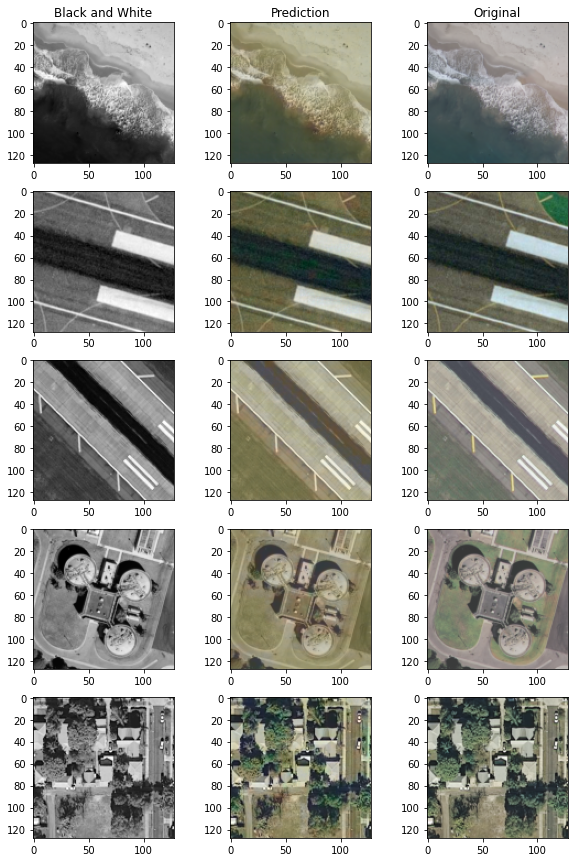

In [18]:
test_num = 5
plt.figure(figsize=(10,15))
for i in range(test_num):
    # getting random image
    sample_image = random.choice(train_image_files)
    image = imread(sample_image)
    image = resize(image, IMAGE_DIMENSION)
    # converting to lab color 
    l, ab = utils.RGB2L_AB(image, IMAGE_DIMENSION)
    # predicting color of black and white image
    predicted_ab = autoencoder.predict(np.expand_dims(l, axis=0))
    colorized_image = utils.L_AB2RGB(l, predicted_ab[0], IMAGE_DIMENSION)

    plt.subplot(test_num,3,i*3 + 1)
    plt.imshow(l.reshape(IMAGE_DIMENSION), cmap='gray')
    if i == 0:
        plt.title('Black and White')
    plt.subplot(test_num,3,i*3 + 2)
    plt.imshow(colorized_image)
    if i == 0:
        plt.title('Prediction')
    plt.subplot(test_num,3,i*3 + 3)
    plt.imshow(image)
    if i == 0:
        plt.title('Original')
plt.show()

In [19]:
test_image_dir = 'test_images'
testing_files = glob(test_image_dir+'/*jpg')
print('FOUND {} IMAGES'.format(len(testing_files)))

FOUND 4 IMAGES


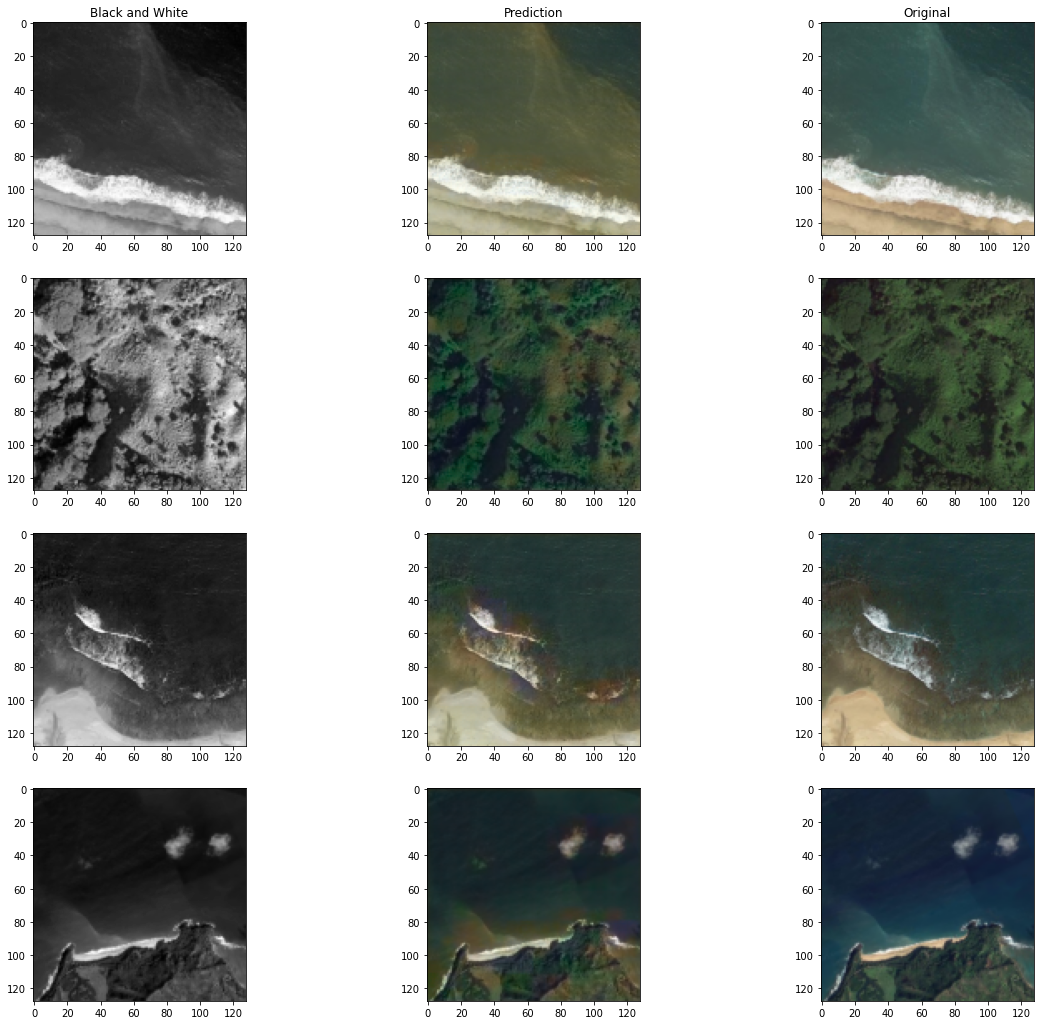

In [20]:
test_num = len(testing_files)
plt.figure(figsize=(20,18))
for i, file in enumerate(testing_files):
    # getting random image
    image = imread(file)
    image = image[:,:,:3]
    image = resize(image, IMAGE_DIMENSION)
    # converting to lab color 
    l, ab = utils.RGB2L_AB(image, IMAGE_DIMENSION)
    # predicting color of black and white image
    predicted_ab = autoencoder.predict(np.expand_dims(l, axis=0))
    colorized_image = utils.L_AB2RGB(l, predicted_ab[0], IMAGE_DIMENSION)

    plt.subplot(test_num,3,i*3 + 1)
    plt.imshow(l.reshape(IMAGE_DIMENSION), cmap='gray')
    if i == 0:
        plt.title('Black and White')
    plt.subplot(test_num,3,i*3 + 2)
    plt.imshow(colorized_image)
    if i == 0:
        plt.title('Prediction')
    plt.subplot(test_num,3,i*3 + 3)
    plt.imshow(image)
    if i == 0:
        plt.title('Original')
plt.show()

In [23]:
autoencoder.save('model/colorizer')

INFO:tensorflow:Assets written to: model/colorizer/assets
